In [1]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from utils import plot_images, train_valid_split
from metric import apk, mapk
import lightgbm as lgb

import faiss
import psutil
from lightfm import LightFM
from scipy import sparse


In [2]:
dataset = '10'

transactions = pd.read_pickle(f"input/{dataset}/transactions_train.pkl")
users = pd.read_pickle(f"input/{dataset}/users.pkl")
items = pd.read_pickle(f"input/{dataset}/items.pkl")
transactions['day'] = (transactions['t_dat'].max() - transactions['t_dat']).dt.days


In [3]:
def lfm(week_start, week_end, target_users):
    NUM_ITEMS = 30
    a = transactions.query("@week_start <= week <= @week_end")
    n_user = len(users)
    n_item = len(items)

    a_train = sparse.lil_matrix((n_user, n_item))
    a_train[a['user'], a['item']] = 1

    no_components = 128
    lightfm_params = {
        'no_components': no_components,
        'learning_schedule': 'adadelta',
        'loss': 'warp',
        'learning_rate': 0.005,
    }

    model = LightFM(**lightfm_params)
    model.fit(a_train, epochs=100, num_threads=psutil.cpu_count(logical=False), verbose=True)
    index = faiss.index_factory(no_components, "Flat", faiss.METRIC_INNER_PRODUCT)
    index = faiss.index_cpu_to_gpu(faiss.StandardGpuResources(), 0, index)
    index.add(model.item_embeddings)
    _, idxs = index.search(model.user_embeddings, NUM_ITEMS)

    return pd.DataFrame({
        'user': np.repeat(target_users, NUM_ITEMS),
        'item': idxs[target_users].flatten(),
        'lfm_rank': list(range(NUM_ITEMS)) * len(target_users),
    })


In [4]:
def create_candidates(transactions: pd.DataFrame, target_users: np.ndarray, week: int) -> pd.DataFrame:
    """
    transactions
        original transactions (user, item, week)
    target_users, week
        候補生成対象のユーザー
        weekで指定されている週の段階での情報のみから作られる
    """
    assert len(target_users) == len(set(target_users))

    def create_candidates_repurchase(
            prefix: str,
            transactions: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
            week_end: int) -> pd.DataFrame:
        tr = transactions.query(
            "user in @target_users and @week_start <= week <= @week_end")[['user', 'item', 'week']].drop_duplicates(ignore_index=True)

        gr_week = tr.groupby(['user', 'item'])['week'].min().reset_index(name='week')
        gr_volume = tr.groupby(['user', 'item']).size().reset_index(name='volume')

        gr_week['week_rank'] = gr_week.groupby('user')['week'].rank()
        gr_volume['volume_rank'] = gr_volume.groupby('user')['volume'].rank()

        candidates = gr_week.merge(gr_volume, on=['user', 'item'])
        candidates = candidates[['user', 'item', 'week_rank', 'volume_rank']].rename(
            columns={'week_rank': f'{prefix}_week_rank', 'volume_rank': f'{prefix}_volume_rank'})
        return candidates

    def create_candidates_popular(
            prefix: str,
            transactions: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
            week_end: int) -> pd.DataFrame:
        NUM_POPULAR_ITEMS = 24
        tr = transactions.query("@week_start <= week <= @week_end")[['user', 'item']].drop_duplicates(ignore_index=True)
        popular_items = tr['item'].value_counts().index.values[:NUM_POPULAR_ITEMS]
        popular_items = pd.DataFrame({
            'item': popular_items,
            'rank': range(NUM_POPULAR_ITEMS),
            'crossjoinkey': 1,
        })

        candidates = pd.DataFrame({
            'user': target_users,
            'crossjoinkey': 1,
        })

        candidates = candidates.merge(popular_items, on='crossjoinkey').drop('crossjoinkey', axis=1)
        candidates = candidates.rename(columns={'rank': f'{prefix}_rank'})
        return candidates

    def create_candidates_popular_index_group_name(
            prefix: str,
            transactions: pd.DataFrame,
            items: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
            week_end: int,
            index_group_name: str) -> pd.DataFrame:
        NUM_POPULAR_ITEMS = 3
        tr = transactions.query("@week_start <= week <= @week_end")[['user', 'item']].drop_duplicates(ignore_index=True)
        tr = tr.merge(items[['item', 'index_group_name']], on='item').query(
            "index_group_name == @index_group_name").drop('index_group_name', axis=1).reset_index(drop=True)

        popular_items = tr['item'].value_counts().index.values[:NUM_POPULAR_ITEMS]
        popular_items = pd.DataFrame({
            'item': popular_items,
            'rank': range(NUM_POPULAR_ITEMS),
            'crossjoinkey': 1,
        })

        candidates = pd.DataFrame({
            'user': target_users,
            'crossjoinkey': 1,
        })

        candidates = candidates.merge(popular_items, on='crossjoinkey').drop('crossjoinkey', axis=1)
        candidates = candidates.rename(columns={'rank': f'{prefix}_rank'})
        return candidates

    def create_candidates_cooc(
            prefix: str,
            transactions: pd.DataFrame,
            week_start: int,
            week_end: int,
            base_candidates: pd.DataFrame) -> pd.DataFrame:
        tr = transactions.query("@week_start <= week == @week_end")[['user', 'item', 'week']].drop_duplicates(ignore_index=True)
        tr = tr.merge(tr.rename(columns={'item': 'item_with', 'week': 'week_with'}), on='user').query(
            "item != item_with and week <= week_with")[['item', 'item_with']].reset_index(drop=True)
        gr_sz = tr.groupby('item').size().reset_index(name='tot')
        gr_cnt = tr.groupby(['item', 'item_with']).size().reset_index(name='cnt')
        item2item = gr_cnt.merge(gr_sz, on='item')
        item2item['ratio'] = item2item['cnt'] / item2item['tot']
        item2item = item2item.query("ratio >= 0.02").reset_index(drop=True)

        base_candidates_columns = [c for c in base_candidates.columns if c not in ['user', 'item', 'week']]
        replace = {c: f"{prefix}_{c}" for c in base_candidates_columns}
        candidates = base_candidates.merge(item2item, on='item').drop(
            ['item', 'cnt'], axis=1).rename(columns={'item_with': 'item'}).rename(columns=replace)
        candidates = candidates.rename(columns={'ratio': f'{prefix}_ratio', 'tot': f'{prefix}_tot'})
        return candidates

    def create_candidates_same_product_code(
            prefix: str,
            items: pd.DataFrame,
            base_candidates: pd.DataFrame) -> pd.DataFrame:
        item2item = items[['item', 'product_code']].merge(items[['item', 'product_code']].rename(
            {'item': 'item_with'}, axis=1), on='product_code')[['item', 'item_with']].query("item != item_with").reset_index(drop=True)

        base_candidates_columns = [c for c in base_candidates.columns if c not in ['user', 'item', 'week']]
        replace = {c: f"{prefix}_{c}" for c in base_candidates_columns}
        candidates = base_candidates.merge(
            item2item,
            on='item').drop(
            'item',
            axis=1).rename(
            columns={
                'item_with': 'item'}).rename(
                    columns=replace)
        return candidates

    candidates = [
        create_candidates_repurchase('repurchase', transactions, target_users, week, week + 3),

        # create_candidates_popular_index_group_name(
        #     'pop_ladieswear', transactions, items, target_users, week, week, 'Ladieswear'),
        # create_candidates_popular_index_group_name('pop_divided', transactions, items, target_users, week, week, 'Divided'),
        # create_candidates_popular_index_group_name(
        #     'pop_menswear', transactions, items, target_users, week, week, 'Menswear'),
        # create_candidates_popular_index_group_name('pop_sport', transactions, items, target_users, week, week, 'Sport'),
        # create_candidates_popular_index_group_name(
        #     'pop_baby', transactions, items, target_users, week, week, 'Baby/Children'),
    ]
    candidates.append(create_candidates_cooc('cooc', transactions, week, week + 9, candidates[0]))
    candidates.append(create_candidates_same_product_code('same_product_code', items, candidates[0]))
    candidates.append(create_candidates_popular('pop', transactions, target_users, week, week))
    # candidates.append(lfm(week, week + 3, target_users))

    volumes = np.array([len(c) for c in candidates])
    print(volumes, volumes / np.sum(volumes))

    # return pd.concat(candidates).reset_index(drop=True)
    candidates = pd.concat(candidates)
    print(f'candidates before drop duplicates: {len(candidates)}')
    candidates.drop_duplicates(subset=['user', 'item'], inplace=True, keep='first')
    print(f'candidates after drop duplicates: {len(candidates)}')
    return candidates.reset_index(drop=True)


In [5]:
# valid: week=1
# train: week=2..1+num_train_weeks
num_train_weeks = 4
candidates = []
for week in range(1, 2+num_train_weeks):
    target_users = transactions[transactions['week'] == week]['user'].unique()
    candidates.append(create_candidates(transactions, target_users, week+1))

[ 15655  73970  88114 164160] [0.04578838 0.21635044 0.25771938 0.4801418 ]
candidates before drop duplicates: 341899
candidates after drop duplicates: 319306
[ 16932  89037  96108 171576] [0.04531477 0.23828793 0.25721191 0.45918539]
candidates before drop duplicates: 373653
candidates after drop duplicates: 347182
[ 17702 111958  97679 183984] [0.04303674 0.27218998 0.23747517 0.44729811]
candidates before drop duplicates: 411323
candidates after drop duplicates: 384538
[ 18990 135336 104946 190872] [0.0421865  0.30065046 0.23313873 0.42402431]
candidates before drop duplicates: 450144
candidates after drop duplicates: 419451
[ 18357 135562 101250 174384] [0.04273512 0.31558853 0.23571015 0.4059662 ]
candidates before drop duplicates: 429553
candidates after drop duplicates: 397174


In [6]:
def merge_labels(candidates: pd.DataFrame, week: int) -> pd.DataFrame:
    """
    候補にラベルを付与する
    候補のうちweekで指定される週にトランザクションがあるなら1
    そうでないなら0
    """
    labels = transactions.query("week == @week")[['user', 'item']].drop_duplicates(ignore_index=True)
    labels['y'] = 1
    original_positives = len(labels)
    labels = candidates.merge(labels, on=['user', 'item'], how='left')
    labels['y'] = labels['y'].fillna(0)
    remaining_positives = labels[['user', 'item', 'y']].drop_duplicates(ignore_index=True)['y'].sum()
    recall = remaining_positives / original_positives
    print(f"Recall: {recall}")
    return labels

def merge_labels_with_positive_exclusion(candidates: pd.DataFrame, week: int, week_start: int, week_end: int) -> pd.DataFrame:
    """
    候補に実際の正例をくっつける
    merge_labelsの後、次の条件を満たす負例を除去する
    条件：[week_start, week_end]で指定される週のトランザクションに含まれる
    """
    labels = merge_labels(candidates, week)

    excluded_positives = transactions.query("@week_start <= week <= @week_end")[['user', 'item']].drop_duplicates(ignore_index=True)
    excluded_positives['flag'] = 1
    labels = labels.merge(excluded_positives, on=['user', 'item'], how='left')
    labels['flag'] = labels['flag'].fillna(0)
    labels = labels.query("flag == 0 or y == 1").reset_index(drop=True)

    return labels


In [7]:
candidates[0] = merge_labels(candidates[0], 1)
candidates[1] = merge_labels(candidates[1], 2)
for idx in range(2, num_train_weeks+1):
    candidates[idx] = merge_labels_with_positive_exclusion(candidates[idx], idx+1, 2, idx)

Recall: 0.08006056591274723
Recall: 0.0667197241013397
Recall: 0.06855076120783918
Recall: 0.06465432535471446
Recall: 0.06354627872654438


In [8]:
def get_query_group(df):
    def run_length_encoding(sequence):
        comp_seq_index, = np.concatenate(([True], sequence[1:] != sequence[:-1], [True])).nonzero()
        return sequence[comp_seq_index[:-1]], np.ediff1d(comp_seq_index)
    users = df['user'].values
    _, group = run_length_encoding(users)
    return list(group)

def drop_trivial_users(labels):
    """
    LightGBMのxendgcやlambdarankでは正例のみや負例のみのuserは学習に無意味なのと、メトリックの計算がおかしくなるので省く
    """
    bef = len(labels)
    df = labels[labels['user'].isin(labels[['user', 'y']].drop_duplicates().groupby(
        'user').size().reset_index(name='sz').query("sz==2").user)].reset_index(drop=True)
    aft = len(df)
    print(f"drop trivial queries: {bef} -> {aft}")
    return df


def calc_query_groups(labels):
    """
    userでソートして、データセットに与える必要があるグループを計算する
    user, y
    """
    df = labels.sort_values(by='user').reset_index(drop=True)
    group = get_query_group(df)
    return df, group


In [9]:
for idx in range(len(candidates)):
    candidates[idx]['week'] = 1+idx

valid_all = candidates[0].copy()

for idx in range(len(candidates)):
    candidates[idx] = drop_trivial_users(candidates[idx])


drop trivial queries: 319306 -> 84821
drop trivial queries: 347182 -> 82443
drop trivial queries: 384342 -> 98108
drop trivial queries: 419055 -> 100622
drop trivial queries: 396769 -> 101703


In [10]:
def attach_features(transactions: pd.DataFrame, users: pd.DataFrame, items: pd.DataFrame, candidates: pd.DataFrame, week: int) -> pd.DataFrame:
    """
    week: これを含めた以前の情報は使って良い
    """
    n_original = len(candidates)
    df = candidates.copy()

    # user static features
    user_features = ['FN', 'Active', 'age', 'club_member_status_idx', 'fashion_news_frequency_idx']
    df = df.merge(users[['user'] + user_features], on='user')

    # item static features
    item_features = [c for c in items.columns if c.endswith('idx')]
    df = df.merge(items[['item'] + item_features], on='item')

    # user dynamic features (transactions)
    num_weeks = 6
    week_end = week + num_weeks
    tmp = transactions.query("@week <= week < @week_end").groupby('user')[['price', 'sales_channel_id']].agg(['mean', 'std'])
    tmp.columns = ['user_' + '_'.join(a) for a in tmp.columns.to_flat_index()]
    df = df.merge(tmp, on='user', how='left')

    # item dynamic features (transactions)
    num_weeks = 6
    week_end = week + num_weeks
    tmp = transactions.query("@week <= week < @week_end").groupby('item')[['price', 'sales_channel_id']].agg(['mean', 'std'])
    tmp.columns = ['item_' + '_'.join(a) for a in tmp.columns.to_flat_index()]
    df = df.merge(tmp, on='item', how='left')

    # item dynamic features (user features)
    num_weeks = 6
    week_end = week + num_weeks
    tmp = transactions.query("@week <= week < @week_end").merge(users[['user', 'age']], on='user')
    tmp = tmp.groupby('item')['age'].agg(['mean', 'std'])
    tmp.columns = [f'age_{a}' for a in tmp.columns.to_flat_index()]
    df = df.merge(tmp, on='item', how='left')

    # item freshness features
    tmp = transactions.query("@week <= week").groupby('item')['week'].min().reset_index(name='item_week_min')
    tmp['item_week_min'] -= week
    df = df.merge(tmp, on='item', how='left')

    # item volume features
    num_weeks = 1
    week_end = week + num_weeks
    tmp = transactions.query("@week <= week < @week_end").groupby('item').size().reset_index(name='item_volume')
    df = df.merge(tmp, on='item', how='left')

    # user freshness features
    # tmp = transactions.query("@week <= week").groupby('user')['week'].min().reset_index(name='user_week_min')
    # tmp['user_week_min'] -= week
    # df = df.merge(tmp, on='user', how='left')

    # user volume features
    # num_weeks = 1
    # week_end = week + num_weeks
    # tmp = transactions.query("@week <= week < @week_end").groupby('user').size().reset_index(name='user_volume')
    # df = df.merge(tmp, on='user', how='left')

    # user-item freshness features
    tmp = transactions.query("@week <= week").groupby(['user', 'item'])['week'].min().reset_index(name='user_item_week_min')
    tmp['user_item_week_min'] -= week
    df = df.merge(tmp, on=['item', 'user'], how='left')

    # user-item volume features
    num_weeks = 1
    week_end = week + num_weeks
    tmp = transactions.query("@week <= week < @week_end").groupby(['user', 'item']).size().reset_index(name='user_item_volume')
    df = df.merge(tmp, on=['user', 'item'], how='left')

    assert len(df) == n_original
    return df


valid_all = attach_features(transactions, users, items, valid_all, 2)
for idx in range(len(candidates)):
    candidates[idx] = attach_features(transactions, users, items, candidates[idx], 2+idx)

In [11]:
datasets = []
for idx in range(len(candidates)):
    datasets.append(calc_query_groups(candidates[idx]))

valid, group_valid = datasets[0]

def concat_train(datasets, begin, num):
    train = pd.concat([datasets[idx][0] for idx in range(begin, begin+num)])
    group_train = []
    for idx in range(begin, begin+num):
        group_train += datasets[idx][1]
    return train, group_train

train, group_train = concat_train(datasets, 1, num_train_weeks)

In [12]:
feature_columns = [c for c in valid.columns if c not in ['y', 'week']]
print(feature_columns)


['user', 'item', 'repurchase_week_rank', 'repurchase_volume_rank', 'cooc_repurchase_week_rank', 'cooc_repurchase_volume_rank', 'cooc_tot', 'cooc_ratio', 'same_product_code_repurchase_week_rank', 'same_product_code_repurchase_volume_rank', 'pop_rank', 'FN', 'Active', 'age', 'club_member_status_idx', 'fashion_news_frequency_idx', 'product_type_no_idx', 'product_group_name_idx', 'graphical_appearance_no_idx', 'colour_group_code_idx', 'perceived_colour_value_id_idx', 'perceived_colour_master_id_idx', 'department_no_idx', 'index_code_idx', 'index_group_no_idx', 'section_no_idx', 'garment_group_no_idx', 'user_price_mean', 'user_price_std', 'user_sales_channel_id_mean', 'user_sales_channel_id_std', 'item_price_mean', 'item_price_std', 'item_sales_channel_id_mean', 'item_sales_channel_id_std', 'age_mean', 'age_std', 'item_week_min', 'item_volume', 'user_item_week_min', 'user_item_volume']


In [13]:
train_dataset = lgb.Dataset(train[feature_columns], train['y'], group=group_train)
valid_dataset = lgb.Dataset(valid[feature_columns], valid['y'], group=group_valid, reference=train_dataset)


In [14]:
params = {
    'objective': 'xendcg',
    'boosting_type': 'gbdt',
    'learning_rate': 1e-3,
    'num_leaves': 255,
    'min_data_in_leaf': 100,
    'metric': 'map',
    'eval_at': 12,
}

model = lgb.train(
    params, train_dataset, valid_sets=[
        train_dataset, valid_dataset], num_boost_round=1000, callbacks=[lgb.early_stopping(50)])


[LightGBM] [Info] Total groups: 4934, total data: 382876
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4802
[LightGBM] [Info] Number of data points in the train set: 382876, number of used features: 41
[LightGBM] [Info] Total groups: 1241, total data: 84821
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[133]	training's map@12: 0.38138	valid_1's map@12: 0.276334


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

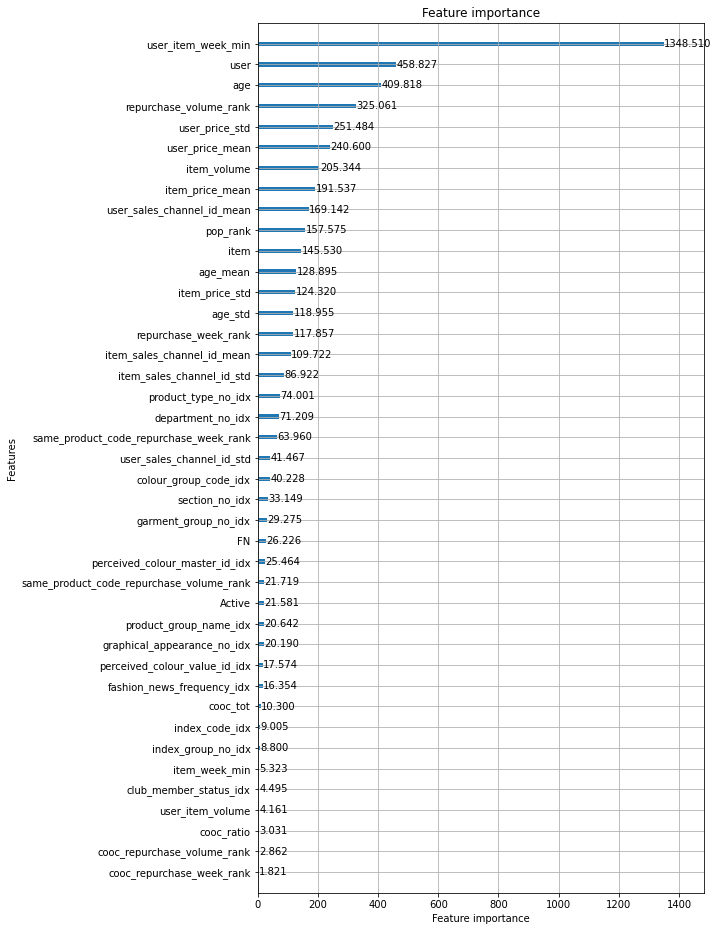

In [15]:
lgb.plot_importance(model, importance_type='gain', figsize=(8, 16))


In [16]:
# recent_items = transactions.query("2 <= week <= 4").item.unique()
# valid_all = valid_all.query("item in @recent_items")


In [17]:
valid_all['pred'] = model.predict(valid_all[feature_columns], num_iteration=model.best_iteration)
pred = valid_all.groupby(['user', 'item'])['pred'].max().reset_index()


In [18]:
pred = pred.sort_values(by=['user', 'pred'], ascending=False).reset_index(
    drop=True).groupby('user')['item'].apply(lambda x: list(x)[:12]).reset_index()
pred


,user,item
0,15,"[82298, 38799, 75431, 80136, 75433, 82299, 856..."
1,34,"[85085, 57699, 84911, 32617, 85105, 54624, 779..."
2,64,"[42628, 1772, 85085, 71832, 84408, 57699, 8142..."
3,83,"[84408, 85434, 78368, 57699, 77946, 85105, 546..."
4,140,"[81769, 81770, 81771, 81772, 85085, 83369, 851..."
...,...,...
6835,137072,"[64274, 66287, 67902, 81890, 81889, 67900, 116..."
6836,137085,"[78368, 57699, 84408, 85434, 85105, 85085, 326..."
6837,137111,"[54624, 57699, 78368, 85105, 85434, 45117, 850..."
6838,137165,"[85085, 78368, 72606, 84408, 85106, 85105, 576..."


In [19]:
gt = transactions[transactions['week'] == 1].groupby('user')['item'].apply(list).reset_index().rename(columns={'item': 'gt'})
merged = gt.merge(pred, on='user', how='left')
merged['item'] = merged['item'].fillna('').apply(list)
merged


,user,gt,item
0,15,"[69908, 84841]","[82298, 38799, 75431, 80136, 75433, 82299, 856..."
1,34,"[56357, 83990, 85848]","[85085, 57699, 84911, 32617, 85105, 54624, 779..."
2,64,"[349, 10062, 17692, 2757, 84814, 83213, 83613,...","[42628, 1772, 85085, 71832, 84408, 57699, 8142..."
3,83,"[55271, 55270]","[84408, 85434, 78368, 57699, 77946, 85105, 546..."
4,140,[71807],"[81769, 81770, 81771, 81772, 85085, 83369, 851..."
...,...,...,...
6835,137072,"[77848, 80462]","[64274, 66287, 67902, 81890, 81889, 67900, 116..."
6836,137085,"[79577, 79577]","[78368, 57699, 84408, 85434, 85105, 85085, 326..."
6837,137111,[39001],"[54624, 57699, 78368, 85105, 85434, 45117, 850..."
6838,137165,"[85679, 85156]","[85085, 78368, 72606, 84408, 85106, 85105, 576..."


In [20]:
mapk(merged['gt'], merged['item'])


0.028709759078750133

In [21]:
assert False

AssertionError: 

submission

In [ ]:
train, group_train = concat_train(datasets, 0, num_train_weeks)

In [ ]:
train_dataset = lgb.Dataset(train[feature_columns], train['y'], group=group_train)
best_iteration = model.best_iteration
model = lgb.train(params, train_dataset, num_boost_round=best_iteration)
lgb.plot_importance(model, importance_type='gain', figsize=(8, 16))

[LightGBM] [Info] Total groups: 51507, total data: 3583498
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.108714 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5243
[LightGBM] [Info] Number of data points in the train set: 3583498, number of used features: 41


KeyboardInterrupt: 

In [ ]:
target_users = users['user'].values
target_users

array([     0,      1,      2, ..., 137195, 137196, 137197])

In [ ]:
candidates = create_candidates(transactions, target_users, 1)

[  91698 3292752  457239  575338] [0.02076012 0.74546794 0.10351737 0.13025458]


In [ ]:
candidates = attach_features(transactions, users, items, candidates, 1)

In [ ]:
candidates['pred'] = model.predict(candidates[feature_columns])
pred = candidates.groupby(['user', 'item'])['pred'].max().reset_index()

In [ ]:
pred = pred.sort_values(by=['user', 'pred'], ascending=False).reset_index(
    drop=True).groupby('user')['item'].apply(lambda x: list(x)[:12]).reset_index()
pred


,user,item
0,0,"[85434, 78596, 85890, 85085, 84911, 32617, 851..."
1,1,"[85434, 78596, 85085, 85890, 84911, 85173, 326..."
2,2,"[54624, 85434, 78596, 85085, 85890, 84911, 851..."
3,3,"[85434, 84911, 85890, 85085, 78596, 32617, 546..."
4,4,"[85434, 84911, 85890, 78596, 85085, 32617, 851..."
...,...,...
137193,137193,"[32617, 85434, 54624, 85173, 84911, 85105, 122..."
137194,137194,"[85434, 54624, 32617, 84911, 85173, 12209, 779..."
137195,137195,"[85434, 85173, 54624, 77931, 85085, 32617, 785..."
137196,137196,"[85434, 12209, 54624, 32617, 85105, 85173, 849..."


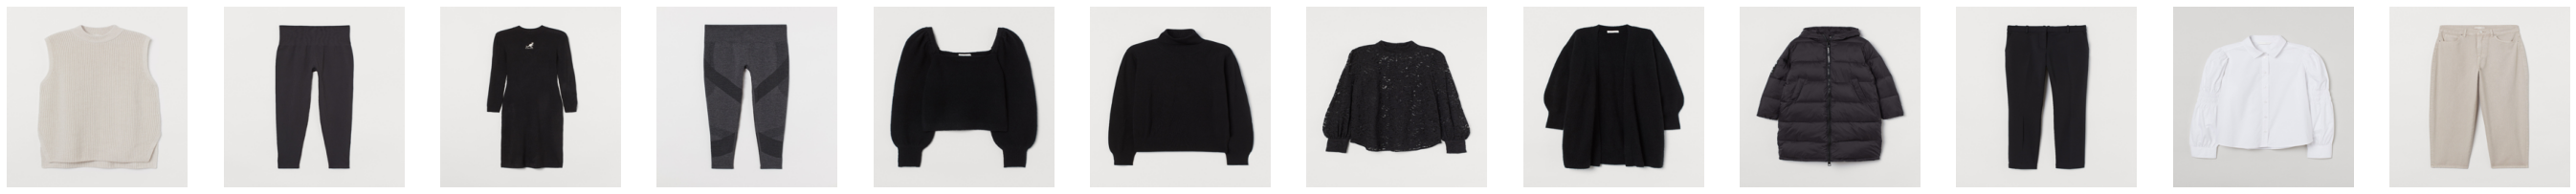

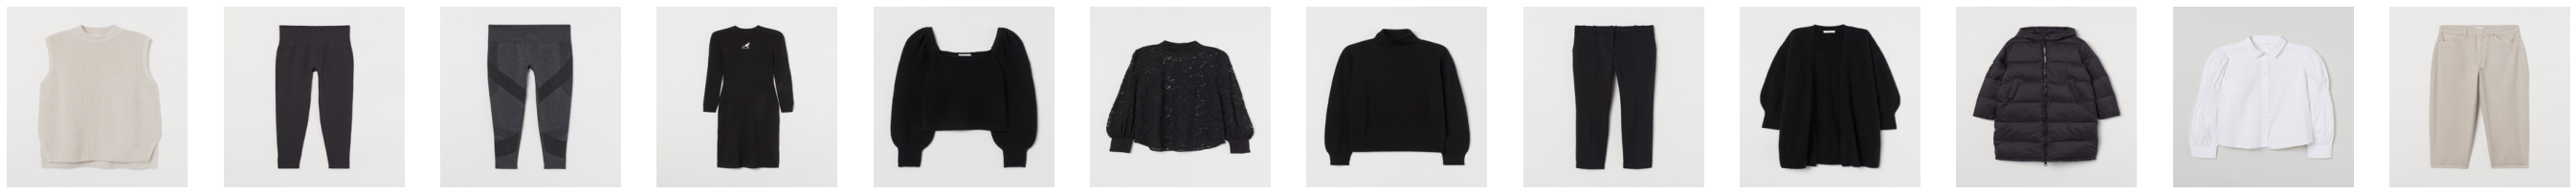

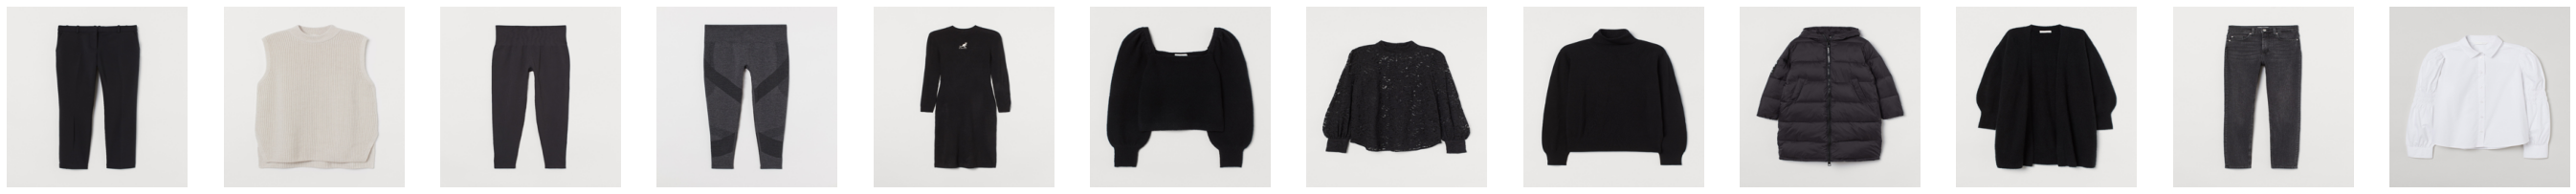

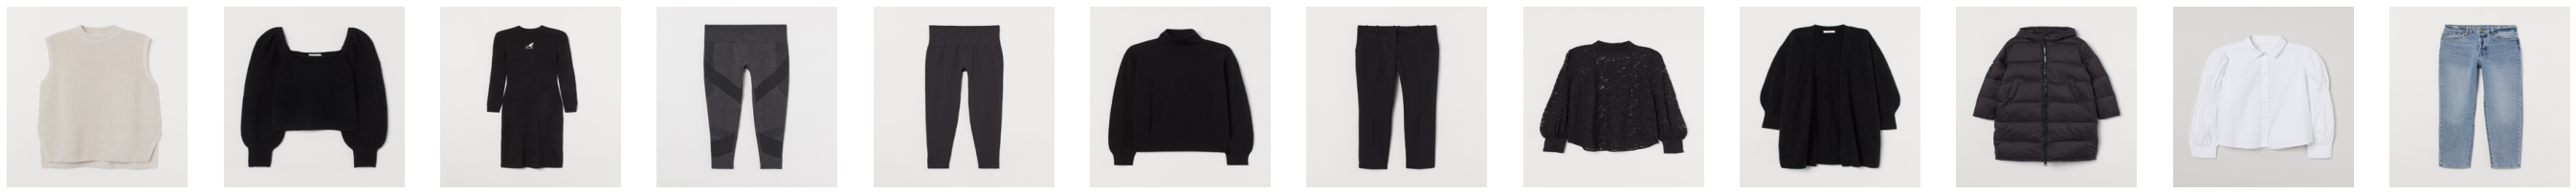

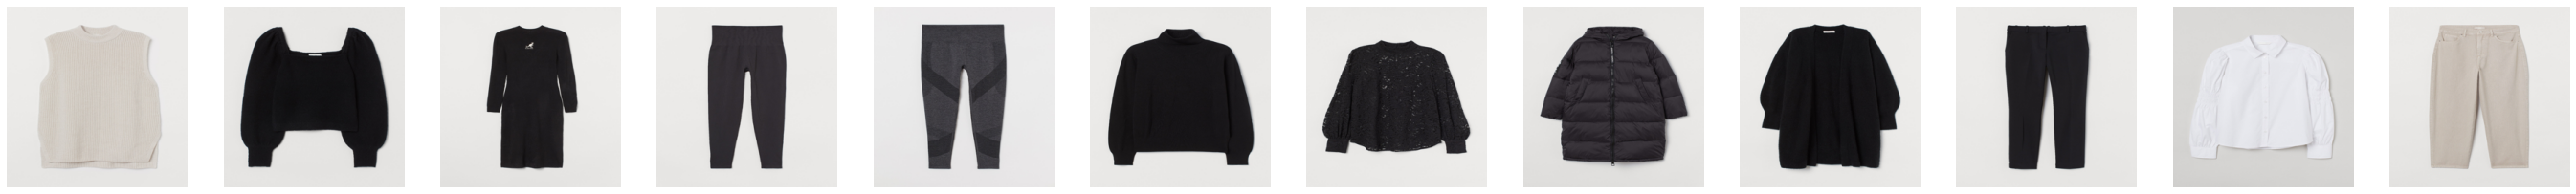

In [ ]:
for i in range(5):
    plot_images(dataset, pred['item'][i])

In [ ]:
mp_user = pd.read_pickle(f"input/{dataset}/mp_customer_id.pkl")
mp_item = pd.read_pickle(f"input/{dataset}/mp_article_id.pkl")

In [ ]:
a_user = mp_user['val'].values
a_item = mp_item['val'].values

In [ ]:
pred['customer_id'] = pred['user'].apply(lambda x: a_user[x])
pred['prediction'] = pred['item'].apply(lambda x: list(map(lambda y: a_item[y], x)))

In [ ]:
pred['prediction'] = pred['prediction'].apply(lambda x: ' '.join(map(str, x)))

In [ ]:
submission = pred[['customer_id', 'prediction']]
submission

,customer_id,prediction
0,0136c28ff3d96e5a5ef25cf5281114d80ab51fc89987eb...,0924243001 0866731001 0935541001 0918292001 09...
1,c51620e1880fd014211558183a6fbfb874311058be572a...,0924243001 0866731001 0918292001 0935541001 09...
2,66d5a61b6e4f13934ebc7f5660e8b140af41ff28511e4e...,0751471001 0924243001 0866731001 0918292001 09...
3,155c36f7720903857396cee8b302b5cbf0785c957a9720...,0924243001 0915529003 0935541001 0918292001 08...
4,5314388cfc57701cf7dc60cb64db82caba655f9355d687...,0924243001 0915529003 0935541001 0866731001 09...
...,...,...
137193,f8d56e4af54ef56347e68c105ccff7a8f8f0913ec1a79c...,0673677002 0924243001 0751471001 0919273002 09...
137194,6166a6b0e2af1809c5cf883894d8e96a845defbde694a2...,0924243001 0751471001 0673677002 0915529003 09...
137195,08f402f06501a51a247d368fe50970e422ad173b29f79e...,0924243001 0919273002 0751471001 0863595006 09...
137196,daf6daf138cdda2ffd5508b5031c8792a4a2c4af28ff41...,0924243001 0573085042 0751471001 0673677002 09...


In [ ]:
submission.to_csv('submission.csv', index=False)